In [1]:
# %pip install umap
# %pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [3]:
base_path = 'C:/Eugenio/Maestria/DMEyF/'

dataset_path = base_path + 'datasets/'
dataset_file = 'competencia_01_fe.csv'

modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

semillas = [122219, 109279, 400391, 401537, 999961]

In [4]:
data = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [5]:
df_train = data[data['foto_mes'] == 202104].copy()

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [6]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

### Random forest distance

In [7]:
# tomamos todos los baja y voy a tomar 2000 continua (probe tambien tomar 10.000 continua pero no me sirvio mucho)

np.random.seed(semillas[3])
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [8]:
Xtrain_rf.shape

(4171, 855)

In [9]:
ytrain_rf.shape

(4171,)

In [10]:
# entrenamos el random forest (imputando missings con la mediana)

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

# model = RandomForestClassifier(n_estimators=100,
#                                max_features=20,
#                                min_samples_leaf=400,
#                                random_state=109279)

# model.fit(Xtrain_rf_imp, ytrain_rf)

In [11]:
# entrenamos el random forest (sin imputar missings)

# scikit-learn added missing values support for random forest in v.1.4
# https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_4_0.html
# "When training every individual tree, the splitter evaluates each potential threshold with the missing values going to the left and right nodes."

model = RandomForestClassifier(n_estimators=100,
                               max_features=0.42,
                               max_depth=15,
                               min_samples_split = 230,
                               min_samples_leaf=125,
                               random_state=semillas[3])

model.fit(Xtrain_rf, ytrain_rf)

RandomForestClassifier(max_depth=15, max_features=0.42, min_samples_leaf=125,
                       min_samples_split=230, random_state=401537)

In [12]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf)

In [13]:
md.shape

(4171, 4171)

In [14]:
md

array([[0.  , 0.51, 1.  , ..., 0.57, 1.  , 1.  ],
       [0.51, 0.  , 1.  , ..., 0.55, 1.  , 1.  ],
       [1.  , 1.  , 0.  , ..., 1.  , 1.  , 0.94],
       ...,
       [0.57, 0.55, 1.  , ..., 0.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 0.  , 1.  ],
       [1.  , 1.  , 0.94, ..., 1.  , 1.  , 0.  ]])

### Embedding

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


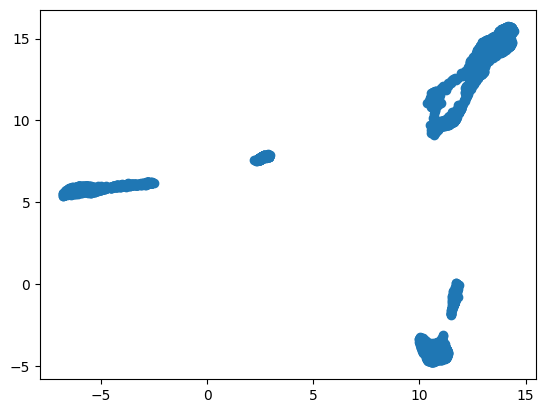

In [15]:
embedding_rf = UMAP(
  n_components=10, 
  n_neighbors=50,
  metric="precomputed",
  random_state=semillas[3],
).fit_transform(md)

# min_dist=0.3, # 0.1 default

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

In [16]:
# este tampoco

# embedding_rf = UMAP(
#   n_components=10, # POR QUE 2 DIMENSIONES NOMAS? PODRIAMOS PROBAR DEJAR MAS DIMENSIONES TOTAL EL CLUSTERING PUEDE USAR MUCHAS DIMENSIONES.
#   n_neighbors=25,
#   metric="precomputed",
#   random_state=semillas[3],
# ).fit_transform(md)

In [17]:
# embedding_rf = UMAP(
#   n_components=10, # POR QUE 2 DIMENSIONES NOMAS? PODRIAMOS PROBAR DEJAR MAS DIMENSIONES TOTAL EL CLUSTERING PUEDE USAR MUCHAS DIMENSIONES.
#   n_neighbors=25,
#   min_dist=0.3, # 0.1 default
#   metric="precomputed",
#   random_state=semillas[3],
# ).fit_transform(md)

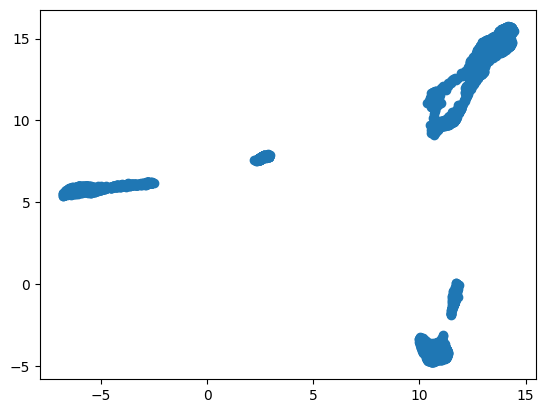

In [18]:
# las primeras 2 dimensiones:

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

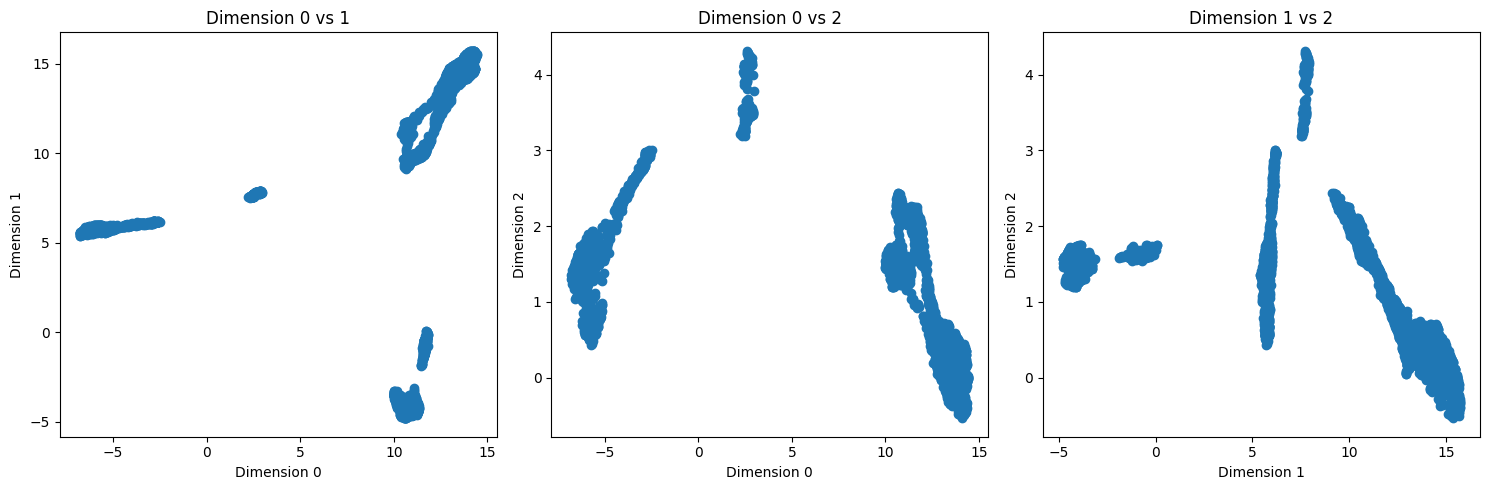

In [19]:
# 3 dimensiones:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first two dimensions (0 vs 1)
axs[0].scatter(embedding_rf[:, 0], embedding_rf[:, 1])
axs[0].set_title('Dimension 0 vs 1')
axs[0].set_xlabel('Dimension 0')
axs[0].set_ylabel('Dimension 1')

# Plot the first and third dimensions (0 vs 2)
axs[1].scatter(embedding_rf[:, 0], embedding_rf[:, 2])
axs[1].set_title('Dimension 0 vs 2')
axs[1].set_xlabel('Dimension 0')
axs[1].set_ylabel('Dimension 2')

# Plot the second and third dimensions (1 vs 2)
axs[2].scatter(embedding_rf[:, 1], embedding_rf[:, 2])
axs[2].set_title('Dimension 1 vs 2')
axs[2].set_xlabel('Dimension 1')
axs[2].set_ylabel('Dimension 2')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
import plotly.graph_objects as go

# Create a 3D scatter plot with no color distinction
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_rf[:, 0],
    y=embedding_rf[:, 1],
    z=embedding_rf[:, 2],
    mode='markers',
    marker=dict(
        size=5,   # Adjust point size
        color='blue',  # Single color for all points
        opacity=0.8
    )
)])

# Set labels and make the plot larger
fig.update_layout(
    title='3D Scatter Plot of Embeddings',
    scene=dict(
        xaxis_title='Dimension 0',
        yaxis_title='Dimension 1',
        zaxis_title='Dimension 2'
    ),
    width=800,  # Make the plot bigger
    height=600
)

# Show the plot
fig.show()

UMAP Parameteres:

The most important parameter is n_neighbors - the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It effectively controls how UMAP balances local versus global structure - low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

The second parameter we’ll investigate is min_dist, or the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

While most applications of UMAP involve projection from high-dimensional data, the projection from 3D serves as a useful analogy to understand how UMAP prioritizes global vs local structure depending on its parameters. As n_neighbors increases, UMAP connects more and more neighboring points when constructing the graph representation of the high-dimensional data, which leads to a projection that more accurately reflects the global structure of the data. At very low values, any notion of global structure is almost completely lost. As the min_dist parameter increases, UMAP tends to "spread out" the projected points, leading to decreased clustering of the data and less emphasis on global structure.

1. Hyperparameters really matter
Choosing good values isn't easy, and depends on both the data and your goals (eg, how tightly packed the projection ought to be). This is where UMAP's speed is a big advantage - By running UMAP multiple times with a variety of hyperparameters, you can get a better sense of how the projection is affected by its parameters.

2. Cluster sizes in a UMAP plot mean nothing
Just as in t-SNE, the size of clusters relative to each other is essentially meaningless. This is because UMAP uses local notions of distance to construct its high-dimensional graph representation.

3. Distances between clusters might not mean anything
Likewise, the distances between clusters is likely to be meaningless. While it's true that the global positions of clusters are better preserved in UMAP, the distances between them are not meaningful. Again, this is due to using local distances when constructing the graph.

Chat GPT:

When you reduce your 600 variables down to two dimensions using UMAP and then apply DBSCAN, you can reasonably interpret that points grouped closely together in the 2D projection likely belong to the same cluster. UMAP is good at maintaining local structure, so within each cluster, points should still reflect some meaningful similarity.

However, when looking at the relative distances between clusters in the UMAP projection, you need to be cautious. As you mentioned, while you may observe two clusters that appear close to each other and a third cluster farther away, the proximity of those clusters in 2D doesn’t necessarily mean the first two clusters are more similar than the third one. UMAP’s distortion of global structure can make these distances less meaningful.

In short: within-cluster proximity is likely meaningful, but between-cluster distances in the UMAP projection should be interpreted with caution

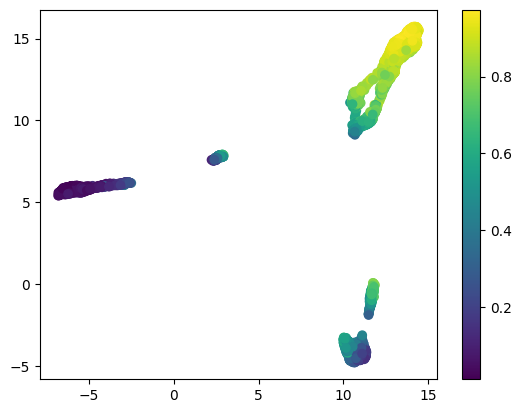

In [21]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

In [22]:
# NO LOGRO QUE ASIGNE COLORES SEGUN PROB_BAJA SI LE QUIERO PONER UNA ESCALA DE COLORES DETERMINADA (EJ VIRIDIS)

import plotly.graph_objects as go

# Create a 3D scatter plot using prob_baja with a color scale
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_rf[:, 0],
    y=embedding_rf[:, 1],
    z=embedding_rf[:, 2],
    mode='markers',
    marker=dict(
        size=5,   
        color=prob_baja,  # Use prob_baja for color
        colorscale='Viridis',  # Specify the colorscale
        showscale=True,  # Show the color scale
        colorbar=dict(title="Probability")  # Optional color bar
    )
)])

# Set labels and make the plot larger
fig.update_layout(
    title='3D Scatter Plot of Embeddings',
    scene=dict(
        xaxis_title='Dimension 0',
        yaxis_title='Dimension 1',
        zaxis_title='Dimension 2'
    ),
    width=800,  # Make the plot bigger
    height=600
)

# Show the plot
fig.show()


### Segmentacion

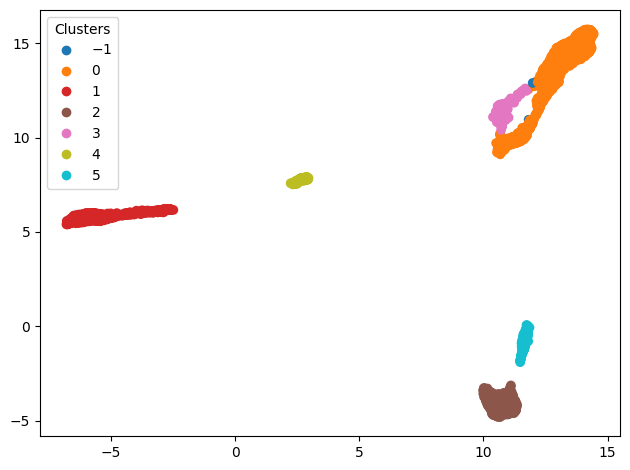

In [23]:
hdb = DBSCAN(eps=0.4) # 0.3 era el valor en el ejemplo
y = hdb.fit(embedding_rf)

scatter = plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')

plt.legend(*scatter.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()

In [24]:
# Create a 3D scatter plot with no color distinction
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_rf[:, 0],
    y=embedding_rf[:, 1],
    z=embedding_rf[:, 2],
    mode='markers',
    marker=dict(
        size=5,   # Adjust point size
        color=y.labels_,  # Single color for all points
        opacity=0.8
    )
)])

# Set labels and make the plot larger
fig.update_layout(
    title='3D Scatter Plot of Embeddings',
    scene=dict(
        xaxis_title='Dimension 0',
        yaxis_title='Dimension 1',
        zaxis_title='Dimension 2'
    ),
    width=800,  # Make the plot bigger
    height=600
)

# Show the plot
fig.show()

In [25]:
pd.Series(y.labels_).value_counts() # los que tienen -1 son outliers que no fueron asignados a ningun cluster

 0    1711
 1     984
 2     805
 3     272
 5     218
 4     173
-1       8
Name: count, dtype: int64

Entonces ahora lo que quiero es volver a juntar Xtrain_rf con ytrain_rf y agregar la columna con el cluster asignado

In [26]:
print(type(Xtrain_rf), Xtrain_rf.shape)
print(type(ytrain_rf), ytrain_rf.shape)
pd.Series(y.labels_).shape

<class 'pandas.core.frame.DataFrame'> (4171, 855)
<class 'pandas.core.series.Series'> (4171,)


(4171,)

In [27]:
Xtrain_rf = Xtrain_rf.reset_index(drop=True)
ytrain_rf = ytrain_rf.reset_index(drop=True)

merged_df = pd.concat([Xtrain_rf, 
                        ytrain_rf.rename('clase_ternaria'),  # Rename the Series
                        pd.Series(y.labels_.astype(int), name='cluster')],  # Create a Series with a name
                       axis=1)

# Check the shape and the first few rows of the merged DataFrame
print(merged_df.shape)
merged_df.head(10)

(4171, 857)


,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,tarjetas_mpagominimo_comp,tarjetas_mfinanciacion_limite_comp,matm_total_comp,tchannel,any_delinquency,total_delinquency,Master_status_v2,Visa_status_v2,clase_ternaria,cluster
0,258586107,202104,1,0,1,66,93,3352.51,25616.29,2652.27,...,-1,-1,0,0,0,0,NaN,20.0,1,0
1,261982034,202104,0,0,1,63,162,1893.31,9803.34,1592.20,...,0,0,0,0,0,0,0.0,0.0,1,0
2,267630599,202104,1,0,0,52,295,3824.22,45969.60,1881.16,...,-1,0,1,1,0,0,0.0,0.0,0,1
3,269475506,202104,1,0,0,49,56,21477.54,160819.88,1592.20,...,0,0,0,0,0,0,NaN,NaN,1,0
4,274751781,202104,1,0,0,68,277,2190.65,28088.05,2382.89,...,-1,0,0,0,0,0,0.0,0.0,1,0
5,277239901,202104,0,0,0,45,37,2890.69,25030.16,1592.20,...,0,0,0,0,0,0,5.0,5.0,1,0
6,277333470,202104,1,0,0,65,98,-4220.57,-5188.78,3760.66,...,1,0,-1,1,0,0,0.0,0.0,0,2
7,280872106,202104,1,0,0,71,261,22988.33,206980.64,1831.56,...,1,0,0,1,0,0,NaN,0.0,0,2
8,281365096,202104,1,0,0,44,99,2240.31,17355.29,2295.24,...,-1,0,0,1,0,0,0.0,0.0,0,1
9,282482708,202104,1,0,0,55,265,2052.92,22209.27,2443.44,...,1,0,-1,1,0,0,0.0,0.0,0,2


In [28]:
merged_df.groupby('cluster')['clase_ternaria'].value_counts().unstack(fill_value=0)

clase_ternaria,0,1
cluster,,
-1,4,4
0,262,1449
1,926,58
2,548,257
3,66,206
4,129,44
5,65,153


In [29]:
# Create a new DataFrame to hold the counts
results = merged_df.groupby('cluster')['clase_ternaria'].value_counts().unstack(fill_value=0)

# Rename the columns for clarity
results.columns = ['continua', 'baja']

# Calculate the total and prob_baja
results['total'] = results['baja'] + results['continua']
results['prob_baja'] = results['baja'] / results['total']

# Reset index to convert the result back to a DataFrame
results.reset_index(inplace=True)

# Sort the DataFrame by 'bajas' in descending order
results.sort_values(by='prob_baja', ascending=False, inplace=True)

total = results[['total','continua','baja','total']].sum()

print(total)

results

total       4171
continua    2000
baja        2171
total       4171
dtype: int64


,cluster,continua,baja,total,prob_baja
1,0,262,1449,1711,0.846873
4,3,66,206,272,0.757353
6,5,65,153,218,0.701835
0,-1,4,4,8,0.500000
3,2,548,257,805,0.319255
5,4,129,44,173,0.254335
2,1,926,58,984,0.058943


### Variables de separacion

In [30]:
df_embedding = pd.DataFrame(embedding_rf)
df_embedding['cluster'] = y.labels_
df_embedding

,0,1,2,3,4,5,6,7,8,9,cluster
0,14.226488,14.785426,0.359742,4.125177,7.262039,6.557940,3.551661,5.571591,6.567038,5.178459,0
1,13.657071,14.915826,-0.054852,4.430919,7.362637,6.663373,4.145153,5.759793,6.404712,5.421959,0
2,-6.259696,5.864081,1.505417,1.168185,7.265326,7.825197,5.023751,7.085761,2.548953,5.137331,1
3,14.362647,15.526793,-0.000978,3.958358,6.661593,6.338878,3.728138,5.730211,6.296769,5.188136,0
4,10.941257,9.813447,2.160582,3.353122,6.224625,5.760132,4.651175,6.481172,5.999072,5.910651,0
...,...,...,...,...,...,...,...,...,...,...,...
4166,11.721022,10.355773,1.842444,2.984330,5.080681,5.762411,3.968415,6.622615,5.879844,5.933007,0
4167,14.055829,14.860970,-0.085460,3.937143,6.196361,6.458061,3.591313,5.811855,6.237584,5.341774,0
4168,14.016233,15.589964,-0.262562,4.282107,7.041072,6.516384,4.116789,5.832968,6.296940,5.381545,0
4169,10.141264,-3.911872,1.581052,4.048187,6.480798,5.329197,4.505486,5.371043,6.141795,6.750297,2


Usaremos random forests para ver que variables son las que distinguen a cada cluster respecto de los demas.

In [31]:
clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int) # arma un vector de 0 y 1 segun es el cluster o no, entonces despues trata de predecir ese cluster

  model = RandomForestClassifier(random_state=semillas[2])
  model.fit(Xtrain_rf, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

In [32]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")

Cluster 0 vs. Resto:
  - avg3_ctrx_quarter
  - ctrx_quarter
  - avg3_Visa_mpagospesos
  - mtarjeta_total_consumo
  - tarjetas_mpagospesos
Cluster 1 vs. Resto:
  - avg3_mpayroll
  - mpayroll
  - avg3_mpayroll_todos
  - cpayroll_trx
  - avg3_cpayroll_trx
Cluster 2 vs. Resto:
  - ctrx_quarter
  - cpayroll_trx
  - avg3_ctrx_quarter
  - avg3_mpayroll
  - mpayroll_todos
Cluster 3 vs. Resto:
  - avg3_ctrx_quarter
  - ctrx_quarter
  - mcaja_ahorro
  - consumos_mas_DA
  - suma_alt
Cluster 4 vs. Resto:
  - ctrx_quarter
  - avg3_ctrx_quarter
  - avg3_mpayroll
  - mpayroll
  - avg3_cpayroll_trx
Cluster 5 vs. Resto:
  - avg3_ctrx_quarter
  - ctrx_quarter
  - cpayroll_trx
  - mpayroll
  - mtarjeta_visa_consumo
Cluster -1 vs. Resto:
  - avg3_cpagomiscuentas
  - slope_avg3_cpagomiscuentas
  - avg3_cplazo_fijo
  - slope_chomebanking_transacciones
  - slope_avg3_Visa_mconsumospesos


Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.

### EDA

In [33]:
merged_df.groupby('cluster').agg({
    'avg3_ctrx_quarter': 'mean',
    'ctrx_quarter': 'mean',
    'cpayroll_trx': 'mean',
    'mpayroll':'mean',
    'mtarjeta_total_consumo': 'mean',
    'tarjetas_mpagospesos': 'mean',
    'mtarjeta_visa_consumo' : 'mean'
})

# bueno bien porque el grupo 5 si tiene movimientos, a diferencia de los grupos 0 y 3

,avg3_ctrx_quarter,ctrx_quarter,cpayroll_trx,mpayroll,mtarjeta_total_consumo,tarjetas_mpagospesos,mtarjeta_visa_consumo
cluster,,,,,,,
-1,147.125000,149.000000,0.000000,0.000000,44967.280000,-40208.925000,37467.696250
0,16.415449,14.775570,0.002338,3.460362,3007.616791,-3863.983723,2719.124763
1,145.180047,145.128049,1.739837,142736.672236,39514.371474,-37354.041585,32916.968699
2,145.225673,145.679503,0.007453,0.000000,60436.560199,-62943.951528,48340.773217
3,30.455270,29.904412,0.022059,50.279853,22548.778529,-22142.439338,19462.278456
4,38.026012,36.485549,1.537572,73990.992486,10269.511156,-9682.993410,9043.785434
5,107.657492,101.330275,0.000000,0.000000,1218.502890,-9861.138991,1040.906560


In [34]:
merged_df.groupby('cluster').agg({
    'mtarjeta_total_consumo': 'mean',
    'tarjetas_mpagospesos': 'mean',
    'mtarjeta_visa_consumo' : 'mean'
}) # 0 y 5 usan muy poco la tarjeta

,mtarjeta_total_consumo,tarjetas_mpagospesos,mtarjeta_visa_consumo
cluster,,,
-1,44967.280000,-40208.925000,37467.696250
0,3007.616791,-3863.983723,2719.124763
1,39514.371474,-37354.041585,32916.968699
2,60436.560199,-62943.951528,48340.773217
3,22548.778529,-22142.439338,19462.278456
4,10269.511156,-9682.993410,9043.785434
5,1218.502890,-9861.138991,1040.906560


AL FINAL DE z202 hay un mini EDA que podemos usar de base.